<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model interpretation using Kernel SHAP (SHapley Additive exPlanations) for  terrestrial water-energy-carbon fluxes

This notebook shows how to apply the Kernel SHAP explainability method on a model trained to predict "**latent heat flux (LEtot)**". The model is a Random Forest model that predicts "LEtot" using a set ofland-atmosphere variables.<br>

The model training workflow and data are based on the research carried by "Qianqian Han" https://doi.org/10.5194/egusphere-egu24-5488 in the context of [EcoExtreML](https://research-software-directory.org/projects/ecoextreml) project. 

Kernel SHAP (SHapley Additive exPlanations) values are a unified measure of feature importance that allocates the contribution of each feature to the prediction for a specific instance. In the context of a regression problem, the interpretation of Kernel SHAP values is as follows:

- **Magnitude**: The magnitude of a SHAP value for a feature indicates the degree to which that feature affects the prediction. A larger absolute SHAP value means that the feature has a stronger impact on the output.
- **Sign**: The sign of a SHAP value indicates the direction of the effect. A positive SHAP value for a feature indicates that the presence of that feature increases the model's output, while a negative SHAP value indicates that the presence of that feature decreases the model's output.
- **Zero**: A SHAP value of zero for a feature indicates that the feature did not contribute to the prediction for that specific instance.

It's important to note that SHAP values are instance-specific. For a general measure of feature importance, you would need to calculate SHAP values for many instances and then aggregate them in some way.

#### Colab Setup

In [ ]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

#### 0 - Libraries

In [1]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.model_selection import train_test_split

import dianna
from dianna import visualization
from dianna.utils import SimpleModelRunner
from dianna.utils.downloader import download

# for plotting purpuses
import io
import shap
import matplotlib.pyplot as plt
from matplotlib.image import imread
from shap import Explanation
from IPython.display import display, HTML

np.random.seed(0)

#### 1- Load and visualize the data

In [2]:
# this data covers only one yearof data i.e. 2014
data_path = download('stemmus_scope_emulator_train_test_2014_data.csv', 'data')

In [3]:
model_input = pd.read_csv(data_path)
model_input

,Unnamed: 0,station,date_UTC,Precip_msr,Rin,Rli,p,Ta,ea,u,...,IGBP_veg_long2,IGBP_veg_long3,IGBP_veg_long4,IGBP_veg_long5,IGBP_veg_long6,IGBP_veg_long7,IGBP_veg_long8,IGBP_veg_long9,IGBP_veg_long10,IGBP_veg_long11
0,0,AU-ASM,2013-12-31 15:00:00,0.0,0.000000,422.350995,940.534220,31.677529,0.087688,2.134386,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,AU-ASM,2013-12-31 16:00:00,0.0,0.000000,405.639800,932.560705,31.299402,0.099312,1.201066,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,AU-ASM,2013-12-31 17:00:00,0.0,0.000000,413.726000,939.196055,30.007821,0.107478,1.354100,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,AU-ASM,2013-12-31 18:00:00,0.0,0.000000,412.545700,940.048085,30.011499,0.110519,1.795051,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,AU-ASM,2013-12-31 19:00:00,0.0,0.000000,381.210585,940.882070,29.375940,0.112046,1.729858,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136583,136583,US-Myb,2014-03-14 22:00:00,0.0,691.839510,315.739010,1023.000000,20.380014,10.184294,2.369500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136584,136584,US-Myb,2014-03-14 23:00:00,0.0,536.578495,315.739010,1022.500000,21.415002,10.509555,1.799000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136585,136585,US-Myb,2014-03-15 00:00:00,0.0,346.486005,309.051010,1022.200000,22.374994,10.878103,1.528500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136586,136586,US-Myb,2014-03-15 01:00:00,0.0,150.326500,302.363010,1022.150000,22.409997,10.705077,1.653500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
# test, train data
model_input['date_UTC'] = pd.to_datetime(model_input['date_UTC'])

x_vars = ['station', 'date_UTC', 'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', *[f'IGBP_veg_long{i}' for i in range(1, 12)]]
x = model_input[x_vars]

y_vars = ['station', 'date_UTC', 'LEtot']
y = model_input[y_vars]

# model was trained on this data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True)

# sort based on time
x_test = x_test.sort_values('date_UTC')
y_test = y_test.sort_values('date_UTC')

x_train = x_train.sort_values('date_UTC')
y_train = y_train.sort_values('date_UTC')

#### 2- Load the model

In [5]:
def preprocess(data):
    data_reshaped = data
    if len(data.shape) == 1:
        data_reshaped = data.reshape(1,-1)
    return data_reshaped.astype(np.float32)

# this model is trained on the data of 2014
model_path = download('stemmus_scope_emulator_model_LEtot.onnx', 'model')
runner = SimpleModelRunner(model_path, preprocess_function=preprocess)

In [6]:
features = x_test.drop(columns=['station', 'date_UTC']).fillna(0)
y_predict = runner(features.to_numpy())
y_actual = y_test.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

relative_mae = np.mean(np.abs(y_predict - y_actual))/ np.mean(y_actual)
cor = np.corrcoef(y_predict.T, y_actual.T)[0,1]
print(f"Relative MAE is {relative_mae} and correlation is {cor}")

Relative MAE is 0.09253918269272535 and correlation is 0.9868130054495278


#### 3 - Example: Run the explainer for one sample (data instance)

This is just an example to know how to set up things with Dianna.

In [7]:
# select one instance of test data
# instances to be explained
features = x_test.drop(columns=['station', 'date_UTC']).fillna(0)
data_instance = features.iloc[0].values.reshape(1, -1)

# The background dataset to use for integrating out features (see shap documentation)
# the number of clusters 5 is determind using kmean inertia plot, see
# https://scikit-learn.org/stable/modules/clustering.html#k-means
background_data = x_train.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

In [8]:
%%time
explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, training_data_kmeans=5,
                                     feature_names=features.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 8.96 s, sys: 4.55 s, total: 13.5 s
Wall time: 2.32 s


In [9]:
%%time
explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, training_data_kmeans=5,
                                     feature_names=features.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 8.69 s, sys: 4.04 s, total: 12.7 s
Wall time: 2.1 s


#### 4 - Visualize the results

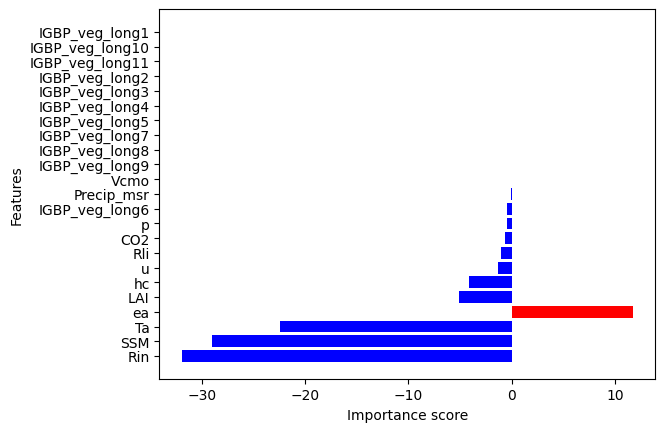

In [10]:
_ = visualization.plot_tabular(explanation[0], features.columns, num_features=len(features.columns))

#### 5 -  Run the explainer at one location, several data instances (here as an example one month time series)

This is an example to get the insights created by Dianna.

##### 5.1 - define some functions for visualizing the results

In [15]:
def display_figures(figures, captions, rows, cols):
    html = "<table>"
    for i in range(rows):
        html += "<tr>"
        for j in range(cols):
            index = i * cols + j
            if index < len(figures):
                fig_data = figures[index]
                fig_data.set_size_inches(10, 8)
                fig_data.savefig(f'fig{index}.png', dpi=100)
                html += f"<td style='word-wrap: break-word; max-width: 500px;'><img src='fig{index}.png'><br><p dir='ltr'>{captions[index]}</p></td>"
            else:
                html += "<td></td>"
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

def comparison_plot(y_actual, y_pred, show=True):
    plt.plot(y_actual, label='Actual', color="blue", linewidth=3, alpha=0.7)
    plt.plot(y_pred, label='Prediction', color="orange")
    plt.xlabel('time index')
    plt.ylabel('LEtot')
    plt.legend()
    if show:
        plt.show()

captions = ["Fig 1: Prediction vs Actual time series using test data. The x axis is time index.", 
            "Fig 2: Heatamp. The x axis is time index. The y axis is the feature names. The colorbar shows the shap values. "
            "The f(x) graph shows the cumulative SHAP values across all features for each sample, "
            "highlighting the relative importance of features across different samples.", 
            "Fig 3: Summary. The x axis is shap values. The colorbar shows the range of each feature values (from low to high)."]

# to store explanations values
explanations = {}

In [16]:
# select one location and time steps
location = "US-Myb"
month = 1
key = f"{location}_{month}"

x_test_time = x_test[(x_test["station"] == location) & (x_test["date_UTC"].dt.month == month)]
features = x_test_time.drop(columns=['station', 'date_UTC']).fillna(0)
background_data = x_train.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

In [18]:
# run explainer over time series
explanations[key] = dianna.explain_tabular(runner, input_tabular=features.values, method='kernelshap',
                                      mode ='regression', training_data=background_data, training_data_kmeans=5,
                                      feature_names=features.columns, silent=True)

print("Dianna is done!") 

Dianna is done!


In [19]:
# create plots
shap_values = Explanation(explanations[key])
shap_values.feature_names = features.columns

# plot predictions vs test data at one location
y_predict_time = runner(features.to_numpy())
y_test_time = y_test[(y_test["station"] == location) & (y_test["date_UTC"].dt.month == month)].drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

comparison_plot(y_test_time, y_predict_time, show=False)    
comparison_img = plt.gcf()
plt.close()

shap.summary_plot(shap_values, features.values, feature_names=features.columns, cmap="PRGn", show=False)
summary_img = plt.gcf()
plt.close()

shap.plots.heatmap(shap_values, cmap="bwr", show=False)
heatmap_img = plt.gcf()
plt.close()

display_figures([comparison_img, heatmap_img, summary_img], captions, 1, 3)

Fig 1: Prediction vs Actual time series using test data. The x axis is time index.,"Fig 2: Heatamp. The x axis is time index. The y axis is the feature names. The colorbar shows the shap values. The f(x) graph shows the cumulative SHAP values across all features for each sample, highlighting the relative importance of features across different samples.",Fig 3: Summary. The x axis is shap values. The colorbar shows the range of each feature values (from low to high).


In [20]:
relative_mae = np.mean(np.abs(y_predict_time - y_test_time))/ np.mean(y_test_time)
cor = np.corrcoef(y_predict_time.T, y_test_time.T)[0,1]
print(f"Relative MAE is {relative_mae} and correlation is {cor}")

Relative MAE is 0.2215188921211095 and correlation is 0.9700512335266412


### Select another location

In [21]:
# select one location and time steps
location = "US-Me6"
month = 1
key = f"{location}_{month}"

# run the explainer
x_test_time = x_test[(x_test["station"] == location) & (x_test["date_UTC"].dt.month == month)]
features = x_test_time.drop(columns=['station', 'date_UTC']).fillna(0)
background_data = x_train.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

In [23]:
# run explainer over time series
explanations[key] = dianna.explain_tabular(runner, input_tabular=features.values, method='kernelshap',
                                      mode ='regression', training_data=background_data, training_data_kmeans=5,
                                      feature_names=features.columns, silent=True)

print("Dianna is done!") 

Dianna is done!


In [24]:
# create plots
shap_values = Explanation(explanations[key])
shap_values.feature_names = features.columns

# plot predictions vs test data at one location
y_predict_time = runner(features.to_numpy())
y_test_time = y_test[(y_test["station"] == location) & (y_test["date_UTC"].dt.month == month)].drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

comparison_plot(y_test_time, y_predict_time, show=False)    
comparison_img = plt.gcf()
plt.close()

shap.summary_plot(shap_values, features.values, feature_names=features.columns, cmap="PRGn", show=False)
summary_img = plt.gcf()
plt.close()

shap.plots.heatmap(shap_values, cmap="bwr", show=False)
heatmap_img = plt.gcf()
plt.close()

display_figures([comparison_img, heatmap_img, summary_img], captions, 1, 3)

Fig 1: Prediction vs Actual time series using test data. The x axis is time index.,"Fig 2: Heatamp. The x axis is time index. The y axis is the feature names. The colorbar shows the shap values. The f(x) graph shows the cumulative SHAP values across all features for each sample, highlighting the relative importance of features across different samples.",Fig 3: Summary. The x axis is shap values. The colorbar shows the range of each feature values (from low to high).


In [25]:
relative_mae = np.mean(np.abs(y_predict_time - y_test_time))/ np.mean(y_test_time)
cor = np.corrcoef(y_predict_time.T, y_test_time.T)[0,1]
print(f"Relative MAE is {relative_mae} and correlation is {cor}")

Relative MAE is 0.22654165750998773 and correlation is 0.9545003829483406


### Select another month

In [26]:
# select one location and time steps
location = "US-Me6"
month = 2
key = f"{location}_{month}"

x_test_time = x_test[(x_test["station"] == location) & (x_test["date_UTC"].dt.month == month)]
features = x_test_time.drop(columns=['station', 'date_UTC']).fillna(0)
background_data = x_train.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

In [27]:
# run explainer over time series
explanations[key] = dianna.explain_tabular(runner, input_tabular=features.values, method='kernelshap',
                                      mode ='regression', training_data=background_data, training_data_kmeans=5,
                                      feature_names=features.columns, silent=True)

print("Dianna is done!") 

Dianna is done!


In [28]:
# create plots
shap_values = Explanation(explanations[key])
shap_values.feature_names = features.columns

# plot predictions vs test data at one location
y_predict_time = runner(features.to_numpy())
y_test_time = y_test[(y_test["station"] == location) & (y_test["date_UTC"].dt.month == month)].drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

comparison_plot(y_test_time, y_predict_time, show=False)    
comparison_img = plt.gcf()
plt.close()

shap.summary_plot(shap_values, features.values, feature_names=features.columns, cmap="PRGn", show=False)
summary_img = plt.gcf()
plt.close()

shap.plots.heatmap(shap_values, cmap="bwr", show=False)
heatmap_img = plt.gcf()
plt.close()

display_figures([comparison_img, heatmap_img, summary_img], captions, 1, 3)

Fig 1: Prediction vs Actual time series using test data. The x axis is time index.,"Fig 2: Heatamp. The x axis is time index. The y axis is the feature names. The colorbar shows the shap values. The f(x) graph shows the cumulative SHAP values across all features for each sample, highlighting the relative importance of features across different samples.",Fig 3: Summary. The x axis is shap values. The colorbar shows the range of each feature values (from low to high).


In [29]:
relative_mae = np.mean(np.abs(y_predict_time - y_test_time))/ np.mean(y_test_time)
cor = np.corrcoef(y_predict_time.T, y_test_time.T)[0,1]
print(f"Relative MAE is {relative_mae} and correlation is {cor}")

Relative MAE is 0.27991943305822775 and correlation is 0.9344053781949128
